### Inversion and Optimisation  <a class="tocSkip"></a>

## Lecture 3: The Conjugate Gradient Method<a class="tocSkip"></a>

## Summary <a class="tocSkip"></a>
Today we continue looking at quadratic minimisation problems, which as we saw yesterday is equivalent to solving  a linear system. And today we will be looking at the Conjugate Gradient (CG) method, which after some further improvements introduced in lecture 4, is in fact the most powerful method for these kinds of problems based on Symmetric Positive Definite systems. 
    
### Important concepts: <a class="tocSkip"></a>
- the Conjugate Gradient method: the role of $\underline{\mathbf{A}}$-orthogonality and the $\underline{\mathbf{A}}$-norm
- the concept of the Krylov Subspace, which will come back in lecture 4

**NOTE:** This notebook contains a fair amount of derivations to derive the specifics of the Conjugate Gradient method. It is not necessary to follow in detail all algebraic steps in these derivations, you just need to know their conclusions, and understand the underlying idea behind the Conjugate Gradient method of looking at distance in a different norm, the $\underline{\mathbf A}$-norm, and using $\underline{\mathbf A}$-orthogonality to derive so called conjugate directions (directions that are $\underline{\mathbf A}$-orthogonal to all previous directions). Execute the following cell to mark all optional material in blue:

In [12]:
%%html
<style>
a.definition {
    color: blue;
    font-style: italic;
    font-weight: bold;
}
div.optional {
    background-color: #e0f0ff;
    border-color: #e0f0ff;
    border-left: 5px solid #80C0ff;
    padding: 0.5em;
}
</style>

In [13]:
# needs to be in separate cell!
%matplotlib inline

In [14]:
# these two lines ensure that imported modules are automatically reloaded when changed
%load_ext autoreload
%autoreload 2
from lecture3 import *  # you need lecture3.py in the same folder

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Steepest Descent for Quadratic Optimisation (summary from yesterday)
In yesterday's lecture we applied the Steepest (or Gradient) Descent method to the problem of quadratic minimisation

$$
  {\bf x}^{(k+1)}
= {\bf x}^{(k)} + \alpha {\bf r}^{(k)}
$$

where we use the definition of the residual vector as

$$
  {\bf r}^{(k)} = {\bf b} - \underline{\mathbf{A}}{\bf x}^{(k)}
$$

which is in fact the opposite of the gradient vector:

$$
  -f'\left({\bf x}^{(k)}\right) = -\left(\underline{\mathbf{A}}{\bf x}^{(k)} - {\bf b}\right) = {\bf r}^{(k)}
$$

We derived an optimal value for $\alpha$ such that along each descent direction we end up in the minimum of $f$ along that line:

<a name="alpha_optimal"></a>
$$
\alpha^* = \frac{{\bf r}^{(k)}\cdot{\bf r}^{(k)}}{{\bf r}^{(k)} \cdot\underline{\mathbf{A}}{\bf r}^{(k)}}
\tag{alpha\_optimal}
\label{alpha_optimal}
$$

We saw however that it's convergence is not very direct in the presence of "narrow valleys", taking a lot of iterations before it comes near to the minimum:

Text(0.5, 0.5, 'y-axis')

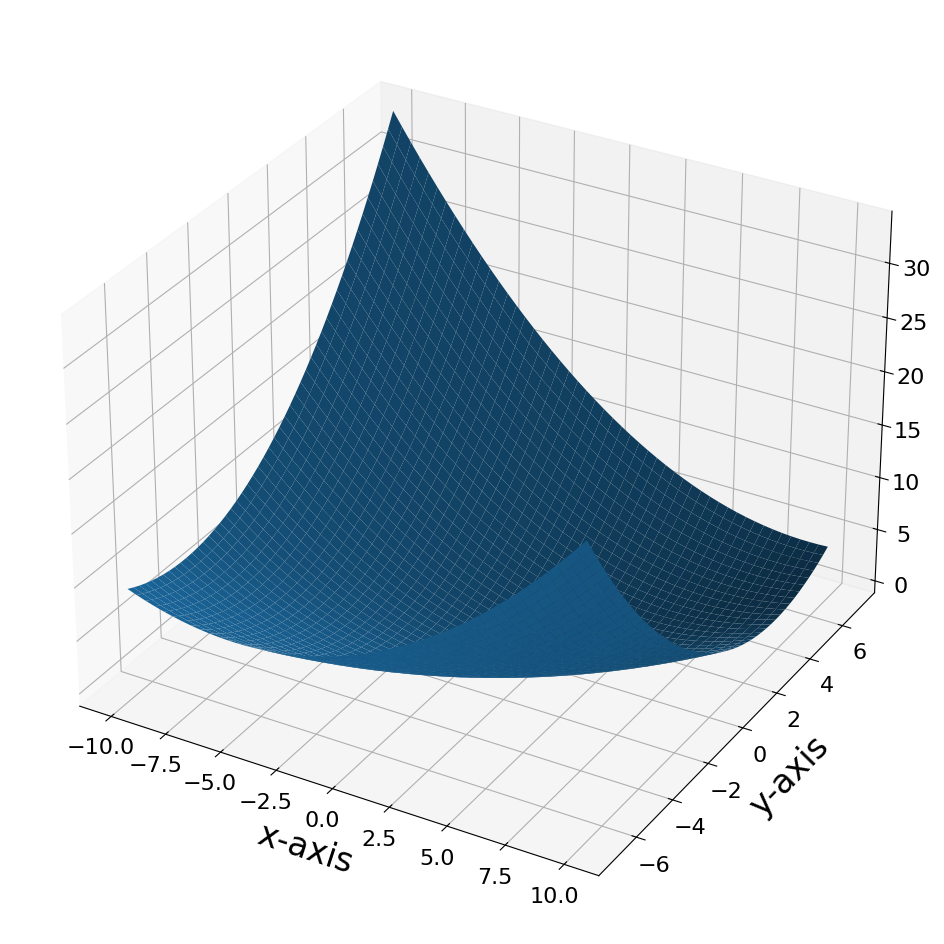

In [15]:
# we set up a quadratic function f(x) = 0.5 x^T A x - b x + c
# as we will see below the contours of this function, are ellipses
# Given the maximum and minimum radius of an ellipse, and the vector that determines
# in which direction the maximum radius occurs (major axis) the function `elliptic_matrix`
# returns the matrix A for which the contour f(x)=1 corresponds to the specified ellipse
v_maj = [2,1]
R_maj, R_min = 5, 2
A = elliptic_matrix(v_maj, R_maj, R_min)

# the minimum of f is in the centre of the ellipses, and as we know
# this minimum location is also the solution of Ax = b
# here, we choose the centre ourselves - and choose b such that
# it is indeed a solution
xs = [3,1]
b = A @ xs

# contruct the quadratic - the constant c=0, but is not relevant
f = quadratic_function(A, b)

# first let's do a 3d surface plot
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1, 1, 1, projection='3d')
x = np.linspace(-10, 10, 50)
y = np.linspace(-7, 7, 50)
# create a Nx x Ny x 2 (Nx=Ny=50) array of grid points
xy = np.array(np.meshgrid(x, y)).T
ax.plot_surface(xy[:,:,0], xy[:,:,1], f(xy))
ax.set_xlabel('x-axis', size=24, labelpad=10)
ax.set_ylabel('y-axis', size=24, labelpad=10)

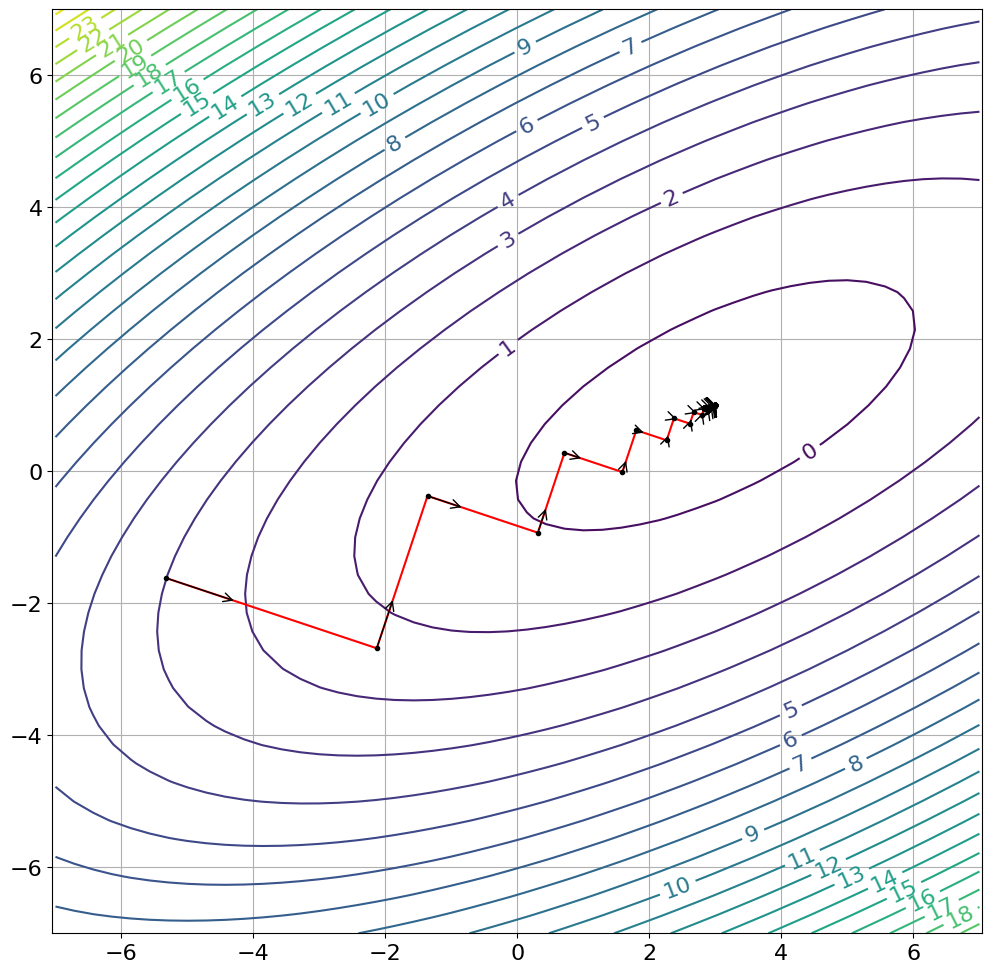

In [16]:
def steepest_descent(A, b, x):
    r = b - A @ x
    alpha_star = np.dot(r, r)/np.dot(r, A @ r)
    return x + alpha_star*r

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.grid()
x = np.linspace(-7, 7, 50)
y = np.linspace(-7, 7, 50)
# create a Nx x Ny x 2 (Nx=Ny=50) array of grid points
xy = np.array(np.meshgrid(x, y)).T
c = ax.contour(xy[:,:,0], xy[:,:,1], f(xy), 25)
ax.clabel(c)
# ensure an equal aspect ratio of x and y
# this is important for angles and arrows pointing in the right direction:
axis = ax.axis('equal')

def arrow(x, dx):
    ax.plot(x[0], x[1], 'k.')
    ax.annotate("", xy=x+dx, xytext=x,
           arrowprops={'arrowstyle': '->'})

cval = c.cvalues[4]
sample_x = sample_points_on_contour(ax, cval, A, b)

sample_x = sample_points_on_contour(ax, cval, A, b)
# same starting point
x0 = sample_x[-1]

for i in range(50):
    x1 = steepest_descent(A, b, x0)

    ax.plot([x0[0], x1[0]], [x0[1], x1[1]], 'r')

    # residual, which is also the gradient of f
    r = A @ x0 - b
    # rescale relative to length of the current step
    r = r/sl.norm(r)*sl.norm(x1-x0)/3.
    arrow(x0, -r)
    
    x0 = x1

# Conjugate gradient

In an ideal world, we would travel in each
direction
exactly as far as required so that we don't need to go in that
direction anymore
in subsequent steps.

We could achieve this by, instead of choosing the minimum of $f$ along our search direction as we did in Steepest Descent, we choose the point along the line that is *closest* to $\bf x^\ast$ as our next iterate ${\bf x}^{(k+1)}$.

As you can see in the figure below that point can also be characterised as the point in which $\bf x^\ast - \bf x^{(k+1)}$, the vector pointing from $\bf x^{(k+1)}$ to $\bf x^\ast$, is *orthogonal* to the line spanned by $\bf p^{(k)}$, the search direction. In the Steepest Descent algorithm we always use the residual vector $\bf r^{(k)}$ as the search direction, i.e. $\bf p^{(k)}=\bf r^{(k)}$, but as we will see further on the directions are modified, so that $\bf p^{(k)}$ may be different to $\bf r^{(k)}$.

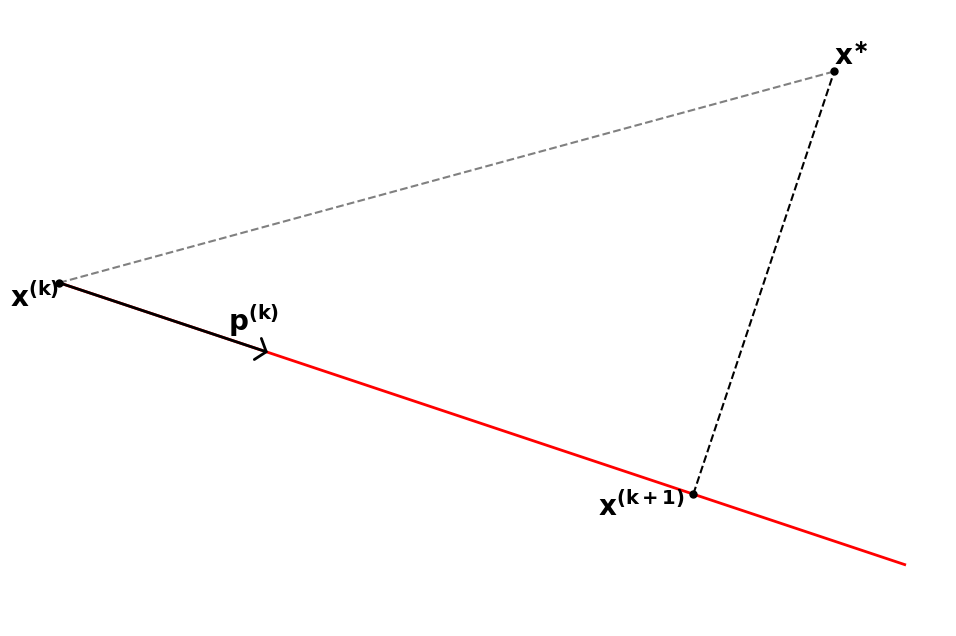

In [17]:
figure6()

This choice of $\bf x^{(k+1)}$ is called the <a class="definition" id="projectionalongaline" href="#definitions">projection of $\bf x^\ast$ along the line</a> spanned by $\bf p^{(k)}$.

## Projection along a line
### Derivation (\*) <a class="tocSkip"></a>
<div class="optional">

Starting at the point ${\bf x}^{(k)}$, if ${\bf p}^{(k)}$ is our search direction, then our new point will be given by

$$
{\bf x}^{(k+1)} =
{\bf x}^{(k)} + \alpha
{\bf p}^{(k)}
$$
</div>

<div class="optional">
Then the squared distance between $\bf x^\ast$ and ${\bf x}^{(k+1)}$ is given by

$$
  \| \bf x^\ast -{\bf x}^{(k+1)} \|^2 = \left( \bf x^\ast -{\bf x}^{(k+1)} \right)^T \left( \bf x^\ast -{\bf x}^{(k+1)} \right)
$$
</div>

<div class="optional">
which through substitution depends on our choice of alpha:
    
$$
  \| \bf x^\ast -{\bf x}^{(k+1)} \|^2
    = \left( \bf x^\ast - {\bf x}^{(k)} - \alpha
{\bf p}^{(k)}
 \right)^T \left( \bf x^\ast - {\bf x}^{(k)} - \alpha
{\bf p}^{(k)}
 \right)
$$
</div>

<div class="optional">
The closest point can be found by minimizing this (squared) distance. Since this distance is just a one-dimensional function of $\alpha$, we can find the minimum by taking the derivative with respect to alpha

\begin{align*}
  \frac{\partial
  \| \bf x^\ast -{\bf x}^{(k+1)} \|^2}{\partial\alpha}
    &=
  \frac{\partial
    \left( \bf x^\ast - {\bf x}^{(k)} - \alpha
{\bf p}^{(k)}  \right)^T }{\partial\alpha}
\left( \bf x^\ast - {\bf x}^{(k)} - \alpha {\bf p}^{(k)} \right) +
      \left( \bf x^\ast - {\bf x}^{(k)} - \alpha
{\bf p}^{(k)}  \right)^T\frac{\partial 
\left( \bf x^\ast - {\bf x}^{(k)} - \alpha {\bf p}^{(k)} \right)}{\partial\alpha} \\
  &= -{{\bf p}^{(k)}}^T \left( \bf x^\ast - {\bf x}^{(k)} - \alpha {\bf p}^{(k)} \right) -
  \left( \bf x^\ast -{\bf x}^{(k)} - \alpha {\bf p}^{(k)} \right)^T {\bf p}^{(k)} \\
    &= -2  \left( \bf x^\ast -{\bf x}^{(k)} - \alpha {\bf p}^{(k)} \right)^T {\bf p}^{(k)} = 0 \\
    &= -2  \left( \bf x^\ast -{\bf x}^{(k+1)} \right)^T {\bf p}^{(k)} = 0
\end{align*}
</div>

<div class="optional">
In other words we have derived that indeed for $\bf x^{(k+1)}$ to be the closest point along the line spanned by $\bf p^{(k)}$, we need $\bf x^\ast - \bf x^{(k+1)}$ to be orthogonal to $\bf p^{(k)}$!
</div>

<div class="optional">
We can now also solve for the $\alpha$ associated with the closest point
\begin{align*}
  \frac{\partial
  \| \bf x^\ast -{\bf x}^{(k+1)} \|^2}{\partial\alpha}
    &= -2  \left( \bf x^\ast -{\bf x}^{(k)} - \alpha
{\bf p}^{(k)} \right)^T {\bf p}^{(k)} \\
  &= -2  \left( \bf x^\ast -{\bf x}^{(k)}\right)^T {\bf p}^{(k)}
+2\alpha{{\bf p}^{(k)}}^T {\bf p}^{(k)} = 0 
 \end{align*}
</div>

<div class="optional">
which we can rearrange to:

$$
\alpha =
\frac{{\bf p}^{(k)} \cdot \left(\bf x^\ast - \bf x^{(k)}\right)}
{{\bf p}^{(k)}\cdot {\bf p}^{(k)}}
$$
</div>

## Projection along a line - summary <a class="tocSkip"></a>

Starting at the point ${\bf x}^{(k)}$, if ${\bf p}^{(k)}$ is our search direction, then our new point will be given by

$$
{\bf x}^{(k+1)} =
{\bf x}^{(k)} + \alpha
{\bf p}^{(k)}
$$

in order for this point to be as close as possible to $x^\ast$ we need to choose

<a name="alpha_orthogonal"></a>
$$
\alpha =
\frac{{\bf p}^{(k)} \cdot \left(\bf x^\ast - \bf x^{(k)}\right)}
{{\bf p}^{(k)}\cdot {\bf p}^{(k)}}
\label{alpha_orthogonal}
\tag{alpha\_orthogonal}
$$

Using this value of $\alpha$ brings us to a new point ${\bf x}^{k+1}$ that's closest to ${\bf x}^\ast$ and for which ${\bf x}^\ast-{\bf x}^{(k+1)}$ is orthogonal to the direction ${\bf p}^{(k)}$ (see figure above).
</div>

## The residual vector and the error vector
Since the result of the previous section depends on $\bf x^\ast$, the solution that we don't know yet, it is not immediately useful to us.

We will make use of the following definiton of the <a class="definition" id="errorvector" href="#definitions">error vector</a> as the (difference) vector between the solution and our iterative approximation:

$$
  \bf e^{(k)} = \bf x^\ast - \bf x^{(k)}
$$

If we multiply the error vector with the matrix $\underline{\bf A}$ we obtain the following important relation between the error vector and the residual vector

\begin{align*}
  \underline{\bf A} \bf e^{(k)} &= \underline{\bf A}\left(\bf x^\ast - \bf x^{(k)}\right) \\
  &= \underline{\bf A}\bf x^\ast - \underline{\bf A}\bf x^{(k)} \\
  &= \bf b - \underline{\bf A}\bf x^{(k)} = {\bf r}^{(k)}
\end{align*}
where in the second line we have used that $\underline{\bf A}\bf x^\ast=\bf b$ because $\bf x^\ast$ is the solution.

<div class="optional">
Using ${\bf e}^{(k)} = {\underline{\bf A}}^{-1} {\bf r}^{(k)}$, we can now express our choice of $\alpha$ purely in terms of the vectors ${\bf r}^{(k)}$ and ${\bf p}^{(k)}$ that we *do* know:

\begin{align*}
\alpha &=
\frac{{\bf p}^{(k)} \cdot\left(\bf x^\ast - \bf x^{(k)}\right)}
{{\bf p}^{(k)}\cdot {\bf p}^{(k)}} \\
&= \frac{{\bf p}^{(k)} \cdot {\underline{\bf A}}^{-1} {\bf r}^{(k)}}
{{\bf p}^{(k)}\cdot {\bf p}^{(k)}}
\end{align*}
</div>

<div class="optional">
Of course this doesn't really help us because it involves applying the inverse of $\underline{\bf A}$ - and if we had a cheap way of doing that we wouldn't need to design a better algorithm of solving $\underline{\bf A}\bf x=\bf b$ in the first place. However, it turns out that by choosing a different definition of orthogonality and distance we can in fact choose $\alpha$ such that the next iteration is closest according to this new definition.
</div>

## Inner Products, Orthogonality and Norms
The definition of orthogonality that
you are probably used to says that two
vectors ${\bf v}$ and ${\bf w}$ are
orthogonal iff

$$
  {\bf v}\cdot{\bf w} = 0
$$

where $\cdot$ signifies the usual
<a class="definition" href="#definitions" id="Euclideaninnerproduct">Euclidean inner product</a> (dot product), i.e.:

$$
  {\bf v}\cdot{\bf w} = {\bf v}^T{\bf w} = \sum_i v_i w_i
$$

We explicitly mention
*Euclidean* here because there
are in fact different inner products that we can
define. To denote these more
general inner products, we'll use the notation
$\langle {\bf v}, {\bf w}\rangle$
for the inner product between vectors ${\bf v}$
and ${\bf w}$.

### Properties of Inner Products (*)  <a class="tocSkip"></a>

<div class="optional">

For a real vector
space $V$ (for our purposes it is sufficient to
think of $V$ as ${\mathbb{R}}^n$) an inner
product is any function $V\times V\to{\mathbb{R}}$,
mapping pairs of vectors in $V$ to a
real number, that satisfies the following
three conditions:
<br>
1. *symmetry*:
$\langle {\bf v}, {\bf w} \rangle = \langle {\bf w}, {\bf v} \rangle$ for all ${\bf v}, {\bf w}\in V$
<br>
2. *linearity*: $\langle {\bf w}, \alpha {\bf u} + {\bf v}\rangle =
\alpha \langle {\bf w}, {\bf u}\rangle +
\langle {\bf w}, {\bf v} \rangle$ for all
${\bf u}, {\bf v}, {\bf w}\in V$ and
$\alpha\in{\mathbb{R}}$
<br>
3. *positivity*: $\langle {\bf v}, {\bf v} \rangle \gt 0$ if ${\bf v}\in V$ and ${\bf v}\neq 0$
<br>
Note that combining 2. and 1., we also have
linearity in the first argument, i.e.:
<br>
$$
\langle \alpha
{\bf u} + {\bf v}, {\bf w}\rangle = \alpha \langle {\bf u}, {\bf w}\rangle + \langle
{\bf v}, {\bf w} \rangle
\text{ for all }{\bf u}, {\bf v}, {\bf w}\in V \text{ and
}\alpha\in{\mathbb{R}}
$$
<br>
and thus
$\langle\cdot, \cdot\rangle$ is a so-called <a class="definition" href="#definitions" id="bilinear">bilinear</a> function.
For the case $V={\mathbb{R}}^n$ any
such function can be written using a $n\times n$
matrix $\underline{\mathbf{A}}$:
<br>
$$
\langle
{\bf v}, {\bf w}\rangle_{\underline{\mathbf{A}}} = {\bf v}^T \underline{\mathbf{A}}
{\bf w}
$$
<br>
In addition, the
properties 1. symmetry, and 3. positivity, mean that
$\underline{\mathbf{A}}$ should be a
Symmetric Positive Definite (SPD) matrix. Vice versa, for
any SPD matrix $\underline{\mathbf{A}}
$ the function $\langle \cdot, \cdot \rangle_{\underline{\mathbf{A}}}$
given above, defines an
inner product.
</div>

In the following we will use the notation $\langle \cdot,
\cdot\rangle_{\underline{\mathbf{A}}}$ for the
<a class="definition" href="#definitions" id="innerproductinducedbyunderlinemathbfA">inner product induced by $\underline{\mathbf{A}}$</a>

$$
\langle
{\bf v}, {\bf w}\rangle_{\underline{\mathbf{A}}} = {\bf v}^T \underline{\mathbf{A}}
{\bf w}
$$

In this notation, the *Euclidean* inner product can
be defined as the inner product induced by the
$n\times n$ identity matrix
$\underline{\mathbf{1}}$

$$
\langle {\bf v}, {\bf w}\rangle_\underline{\mathbf{1}} = {\bf v}^T\underline{\mathbf{1}}{\bf w} 
= {\bf v}^T{\bf w} = {\bf v}\cdot{\bf w}
$$

By choosing a
different inner product than the standard
Euclidean inner product, we also change
the condition for orthogonality. Thus we
should say orthogonal *with respect to*
the specified inner product. For
instance we may call two vectors ${\bf v}$ and
${\bf w}$ orthogonal with respect
to the inner product induced by $\underline{\mathbf{A}}$ if
$\langle {\bf v}, {\bf w}\rangle_{\underline{\mathbf{A}}
}=0$. We will also use <a class="definition" href="#definitions" id="underlinemathbfAorthogonal">$\underline{\mathbf{A}}$-orthogonal</a> for short.

Note that choosing a different
inner product also changes the associated
norm. The <a class="definition" href="#definitions" id="Euclideannorm">Euclidean norm</a> (also called
2-norm) is defined as

$$
  \| {\bf v} \| =
\sqrt{{\bf v}\cdot {\bf v}}.
$$

Thus we
may define a norm induced by $\underline{\mathbf{A}}$, the <a class="definition" href="#definitions" id="underlinemathbfAnorm">$\underline{\mathbf{A}}$-norm</a> for short, as

$$
  \| {\bf v} \|_{\underline{\mathbf{A}}} =
\sqrt{\langle {\bf v}, {\bf v}\rangle_{\underline{\mathbf{A}}}}
  =
\sqrt{{\bf v}^T \underline{\mathbf{A}}{\bf v}}
$$

This norm satisfies all the usual properties
associated with a [normed vector
space](https://en.wikipedia.org/wiki/Normed_vector_space).

We can repeat the steps taken in the previous sections to choose $\alpha$ such that the new point is closest to $\bf x^\ast$ in the $\underline{\bf A}$-norm rather than in the Euclidean norm. It will maybe not surprise you that the vector between this point $\bf x^{(k+1)}$ and $\bf x^{\ast}$ is now $\underline{\bf A}$-orthogonal to the search direction $\bf r^{(k+1)}$ (instead of being orthogonal according to the Euclidean inner product). This means that all we have to do in the formula for $\alpha$ in equation <a href="#alpha_orthogonal">(alpha_orthogonal)</a> above,
is replace the Euclidean inner products with the inner product induced by $\underline{\bf A}$.

$$
\alpha =
\frac{{\bf p}^{(k)} \cdot \left({\bf x}^\ast - {\bf x}^{(k)}\right)}
{{\bf p}^{(k)}\cdot {\bf p}^{(k)}}\quad \longrightarrow \quad
\alpha =
 \frac{\langle {\bf p}^{(k)}, \left({\bf x}^\ast - {\bf x}^{(k)}\right)\rangle_{\underline{\bf A}}}
{\langle {\bf p}^{(k)}, {\bf p}^{(k)}\rangle_{\underline{\bf A}}}
$$

Using the relation between error and residual ${\underline{\bf A}} ({\bf x}^\ast - {\bf x}^{(k)})={\bf r}^{(k)}$ we derived above, it turns out that we can compute this $\alpha$ explicitly:

$$
\alpha =
 \frac{\langle {\bf p}^{(k)}, \left({\bf x}^\ast - {\bf x}^{(k)}\right)\rangle_{\underline{\bf A}}}
{\langle {\bf p}^{(k)}, {\bf p}^{(k)}\rangle_{\underline{\bf A}}}
=
 \frac{{{\bf p}^{(k)}}^T \underline{\bf A} \left({\bf x}^\ast - {\bf x}^{(k)}\right)}
{{{\bf p}^{(k)}}^T \underline{\bf A} {\bf p}^{(k)}}
  = \frac{{{\bf p}^{(k)}}^T  {\bf r}^{(k)}}
  {{{\bf p}^{(k)}}^T {\underline{\bf A}} {\bf p}^{(k)}}
$$

If we go back to the Steepest Descent algorithm, where ${\bf p}^{(k)}={\bf r}^{(k)}$, we in fact have the exact same choice for $\alpha$ as previously. In other words, the Steepest Descent algorithm we described previously, chooses its next point along the line as the point that is closest to the solution in the $\underline{\bf A}$-norm.

## Inner Products and Coordinate Transformations (\*)

<div class="optional">
    
Now it might seem a little
arbitrary to just
choose whatever inner product we like, but it turns out that
there is a very
natural interpretation of different inner products in terms of
coordinate
transformations. 

We have considered our function $f({\bf x})$ to be a
function of
vectors ${\bf x}\in {\mathbb{R}}^n$, which we may think of as locations, or
coordinates in
${\mathbb{R}}^n$, but what if we choose a different coordinate system?

Suppose there is an
invertible map, a coordinate transformation, between two
coordinate-systems
${\bf x}$ and $\hat{{\bf x}}$ such that $\hat{{\bf x}}=\Phi({\bf x})$, and vice
versa
${\bf x}=\Phi^{-1}(\hat{{\bf x}})$. 
For simplicity, let's
assume that
$\Phi$ is linear, and we write $\hat{{\bf x}} = \underline{\mathbf{\Phi}}{\bf x}$ where
$\underline{\mathbf{\Phi}}$
is now an (invertible) matrix. This has the advantage that movement
along a line
in ${\bf x}$-space is still along a line in $\hat{{\bf x}}$-space. If
in ${\bf x}$-space we take the step:

$$
  {\bf x}^{(k+1)} = {\bf x}^{(k)} + \alpha
{\bf p}^{(k)}
$$

then in $\hat{{\bf x}}$-space the same step looks like:

\begin{align*}
\hat{{\bf x}}^{(k+1)} &= \underline{\mathbf{\Phi}}\left({\bf x}^{(k)} + \alpha
{\bf p}^{(k)}\right)
\\
  &= \underline{\mathbf{\Phi}}{\bf x}^{(k)} + \alpha \underline{\mathbf{\Phi}}{\bf p}^{(k)}
\\
  &= \hat{{\bf x}}^{(k)} + \alpha \underline{\mathbf{\Phi}}{\bf p}^{(k)} \\
\end{align*}

The
error $\hat{{\bf e}}^{(k+1)}$ in $\hat{{\bf x}}$-space works out as

\begin{align*}
\hat{{\bf e}}^{(k+1)} &= \hat{{\bf x}}^* - \hat{{\bf x}}^{(k+1)} \\
  &=
\underline{\mathbf{\Phi}}{{\bf x}}^* -
\underline{\mathbf{\Phi}}{\bf x}^{(k+1)} = \underline{\mathbf{\Phi}} e^{(k+1)}
\end{align*}

Thus if we want the
step $\hat{{\bf x}}^{(k+1)}-\hat{{\bf x}}^{(k)}$ and the error
$\hat{{\bf e}}^{(k+1)}$ to be orthogonal in $\hat{{\bf x}}$-space, we need

\begin{align*}
\left(\alpha\underline{\mathbf{\Phi}} {\bf p}^{(k)}\right)\cdot \underline{\mathbf{\Phi}}{\bf e}^{(k+1)} &= 0 \\
\alpha{\bf p}^{(k)}\cdot \underline{\mathbf{\Phi}}^T\underline{\mathbf{\Phi}}{\bf e}^{(k+1)} &= 0 \\
\alpha\langle {\bf p}^{(k)}, {\bf e}^{(k+1)}\rangle_{\underline{\mathbf{\Phi}}^T\underline{\mathbf{\Phi}}} &= 0
\end{align*}

So instead of demanding
${\bf p}^{(k)}\cdot{\bf e}^{(k+1)}=0$, i.e.
the search direction and the error
should be orthogonal under the Euclidean
inner product, we ask for it to be
orthogonal with respect to the inner product
induced by the matrix
$\underline{\mathbf{\Phi}}^T\underline{\mathbf{\Phi}}$.

<div class="optional">

This is another point at which our assumption that $\underline{\mathbf{A}}$ is a SPD matrix
is very helpful. As we saw before this assumption is necessary for the inner
product induced by $\underline{\mathbf{A}}$ to behave as expected - for example if $\underline{\mathbf{A}}$ is
not positive definite we may end up with a zero $\langle {\bf r}^{(k)}, {\bf r}^{(k)}\rangle_{\underline{\mathbf{A}}}$ in the denominator - but it also guarantees that the
existence of a so called [Cholesky
decomposition](https://en.wikipedia.org/wiki/Cholesky_decomposition), that is to
say: for any SPD matrix $\underline{\mathbf{A}}$, there exist a real matrix $\underline{\mathbf{\Phi}}$, such
that

$$
  \underline{\mathbf{A}} = \underline{\mathbf{\Phi}}^T \underline{\mathbf{\Phi}}
$$

Although we won't need to explicitly
perform the Cholesky decomposition in the conjugate gradient algorithm, it is a
very useful tool in our understanding of it. As we have just derived, choosing ${\bf x}^{(k+1)}$ such that ${\bf x}^\ast-{\bf x}^{(k+1)}$ is $\underline{\bf A}$-orthogonal to ${\bf p}^{(k)}$ is equivalent to ${\bf\hat x}^\ast-{\bf\hat x}^{(k+1)}$ to be orthogonal in ${\bf\hat x}$-space.
    
</div>

## Changing directions

So far we have
seen that if we start at an initial guess
of ${\bf x}^{(0)}$ and decide to head
in the opposite of the direction 
of the gradient (remember the residual 
${\bf r}$ is the negative of the gradient):

$$
  {\bf x}^{(1)} = {\bf x}^{(0)} + \alpha^{(0)}
{\bf r}^{(0)}
$$

and choose $\alpha^{(0)}$
according to

$$
  \alpha^{(0)} =
\frac{{\bf r}^{(0)}\cdot{\bf r}^{(0)}}{{\bf r}^{(0)}\cdot \underline{\mathbf{A}}{\bf r}^{(0)}}
$$

This achieves two things:
1. the new point ${\bf x}^{(1)}$ is where $f$ reaches its minimum along the line through $x^{(0)}$ going in the (opposite) gradient direction ${\bf r}^{(0)}$
2. the step we make is $\underline{\mathbf{A}}$-orthogonal to the error $e^{(1)}$ after the first step:
$$
  \langle
{\bf x}^{(1)} - {\bf x}^{(0)},
{\bf e}^{(1)} \rangle_{\underline{\mathbf{A}}}
  = \langle \alpha^{(0)}{\bf r}^{(0)}, {\bf e}^{(1)}
  \rangle_{\underline{\mathbf{A}}} = 0.
$$

In the previous (optional) section we saw that this $\underline{\mathbf{A}}$-orthogonality is equivalent to (normal Euclidean) orthogonality after some transformation to a different coordinate system $\bf\hat x$, which is illustrated in the next figure
(*the transformation is given by $\hat{{\bf x}}=\underline{\mathbf{\Phi}}{\bf x}$ where $\underline{\mathbf{A}}=\underline{\mathbf{\Phi}}^T\underline{\mathbf{\Phi}}$*).

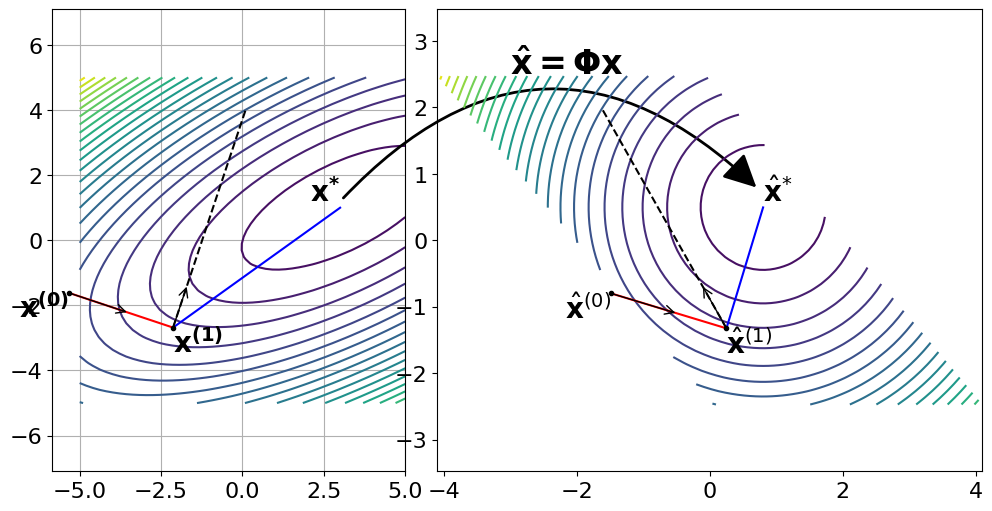

In [18]:
# same starting point
x0 = sample_x[-1]
figure7(x0, A, b)

In the figure above on the left, we have again plotted the first step of
the steepest descent algorithm ${\bf x}^{(0)} \to {\bf x}^{(1)}$ (indicated in red). On the right we
have plotted the same step after the coordinate transformation . As expected, the error
$\hat{{\bf e}}^{(1)}=\hat{{\bf x}}^* - \hat{{\bf x}}^{(1)}$ (indicated in blue) is
orthogonal to the first step direction $\hat{{\bf x}}^{(1)}-\hat{{\bf x}}^{(0)}=\alpha^{(0)}\underline{\mathbf{\Phi}}{\bf r}^{(0)}$. This in fact means that in the
transformed coordinate space we have chosen the point along the (red) line
$\hat{{\bf x}}^{(0)}+\alpha\underline{\mathbf{\Phi}}{\bf r}^{(0)}$ that is *closest* to $\hat{{\bf x}}^*$.

However the direction that we used in the second step of the *steepest
descent algorithm*, based on the gradient/residual ${\bf r}^{(1)}={\bf b} - \underline{\mathbf{A}}
{\bf x}^{(1)}$ (indicated by the black dashed line), after transformation
$\underline{\mathbf{\Phi}}{\bf r}^{(1)}$ is no longer orthogonal to the first step. Thus, going in
this new direction we also change again (and make worse!) the component associated with the direction
of the first step.

We can avoid this by making the next search direction orthogonal to the first search direction, which corresponds to the blue line in the right picture. Orthogonal in the right picture, however means $\underline{\bf A}$-orthogonal in the left picture. This motivates
the choice in the conjugate gradient algorithm to choose our search direction to always be $\underline{\bf A}$-orthogonal to the previous search direction(s). As is derived below (optional material) we choose these so called <a class="definition" href="#definitions" id="conjugateddirections">conjugated directions</a>, as before starting from the residual vector but using another orthogonal projection, this time involving a coefficient $\beta$, to make them $\underline{\bf A}$-orthogonal.

## Conjugate Gradient in two dimensions (\*)
<div class="optional">
We will first derive the conjugate direction ${\bf p}^{(1)}$ used in the second iteration of the Conjugate Gradient method. We have to modify the search direction ${\bf r}^{(1)}$, which is the search direction we would use in steepest descent and is orthogonal to the first search direction, to a new search direction ${\bf p}^{(1)}$ that is $\underline{\bf A}$-orthogonal to the first search direction.

$$
  {\bf p} = {\bf r}^{(1)} + \beta {\bf r}^{(0)}
$$
</div>

<div class="optional">
We impose

\begin{align*}
  {\bf r}^{(0)}\cdot\underline{\mathbf{A}}{\bf p} &= 
  {\bf r}^{(0)}\cdot\left(\underline{\mathbf{A}}{\bf r}^{(1)} + \beta \underline{\mathbf{A}}{\bf r}^{(0)}\right) \\
  &= {\bf r}^{(0)}\cdot\underline{\mathbf{A}}{\bf r}^{(1)}
  + \beta {\bf r}^{(0)}\cdot \underline{\mathbf{A}}{\bf r}^{(0)} =0
\end{align*}
</div>

<div class="optional">
From this we can work out what $\beta$ should be.
</div>

<div class="optional">
We therefore now
propose to change the search direction in the second step to:

$$
  {\bf p}^{(1)}
= {\bf r}^{(1)} + \beta {\bf r}^{(0)}
$$

with

$$
  \beta = -\frac{{\bf r}^{(0)}\cdot \underline{\mathbf{A}}{\bf r}^{(1)}}{{\bf r}^{(0)}\cdot\underline{\mathbf{A}}{\bf r}^{(0)}}
$$

and thus the second iterate changes to

$$
{\bf x}^{(2)} = {\bf x}^{(1)} + \alpha^{(1)}{\bf p}^{(1)}
$$

where $\alpha^{(1)}$
is chosen, as before, to obtain the minimal value of $f$ along the 
chosen
search direction, which now gives:

$$
  \alpha^{(1)} = \frac{{\bf p}^{(1)}\cdot{\bf r}^{(1)}}{{\bf p}^{(1)}\cdot\underline{\mathbf{A}}{\bf p}^{(1)}}
$$
</div>

<div class="optional">
If we look back at the last figure, we have chosen ${\bf p}$ to be $\underline{\mathbf{A}}$-orthogonal to the red line on the left, and $\underline{\mathbf{\Phi}}{\bf p}$ to be orthogonal to the red line on the right. This direction should correspond with the blue which goes straight through the solution ${\bf x}^*$. By making the "optimal" choice for $\alpha^{(1)}$ we therefore expect to land exactly in the solution ${\bf x}^*$. Let's check this with a few lines of python:
</div>

In [19]:
# use same initial guess x0 as before
x0 = sample_x[-1]

# first step - same as steepest descent
r0 = b - A @ x0
alpha0 = np.dot(r0, r0) / np.dot(r0, A @ r0)
x1 = x0 + alpha0 * r0
r1 = b - A @ x1

# second step - we change the direction r1 to a new direction p1
beta = -np.dot(r0, A @ r1)/np.dot(r0, A @ r0)
p1 = r1 + beta*r0
alpha1 = np.dot(p1, r1)/np.dot(p1, A @ p1)
x2 = x1 + alpha1*p1

print('Algorithm after 2 steps:', x2)
print('Analytical answer:', xs)

Algorithm after 2 steps: [3. 1.]
Analytical answer: [3, 1]


## Multiple dimensions (\*)
<div class="optional">
As we have seen previously 
the optimal choice of $\alpha^{(0)}$ means that the error ${\bf e}^{(1)}=
{\bf x}^*-{\bf x}^{(1)}$ after the first step is $\underline{\mathbf{A}}$-orthogonal to the first direction.
In two dimensions, there is only such direction. Therefore if we choose, as we did above ${\bf p}^{(1)}$, the search direction in the second step, to $\underline{\mathbf{A}}$-orthogonal as well to the first search direction, it must be that ${\bf p}^{(1)}$ and ${\bf e}^{(1)}$ are in the same direction. As we have seen this means that we can reach the exact answer ${\bf x}^*$ at the end of the second step using the optimal value of $\alpha^{(1)}$.

In three dimensions, again, the error at the  end of the first step,
is $\underline{\mathbf{A}}$-orthogonal to the first step
direction. This is however not the only direction that is $\underline{\mathbf{A}}$-orthogonal to the first step direction. In fact the different directions, all starting from ${\bf x}^{(1)}$, span a plane that is $\underline{\mathbf{A}}$-orthogonal as a whole to the first search direction. The error at first step ${\bf e}^{(1)}=
{\bf x}^*-{\bf x}^{(1)}$, which lies in this plane, is the vector that points from ${\bf x}^{(1)}$ to ${\bf x}^*$ and therefore the solution ${\bf x}^*$ also lies in the plane.

The second step of the steepest descent algorithm follows ${\bf r}^{(1)}$, but as
in two dimensions, this direction is not $\underline{\mathbf{A}}$-orthogonal to ${\bf r}^{(0)}$,
and therefore does not lie in the plane. We can follow the same procedure as
before, to add the ${\bf r}^{(0)}$ component (scaled by some $beta$), which will give us a search
direction ${\bf p}^{(1)}$ which does lie in the plane. Since, however, we now have
two directions left that lie in the plane, this new direction is not guaranteed
to be in the same direction as the exact error and therefore we will in general
not reach the exact answer in two steps.

Instead in the second step we proceed
in the ${\bf p}^{(1)}$-direction, and choose the point ${\bf x}^{(2)}$ such that
${\bf x}^{(2)}-{\bf x}^{(1)}$ is ${\bf A}$-orthogonal to the error. In principle
this means that after the first step, we have reduced our problem to a
2-dimensional problem, starting at ${\bf x}^{(1)}$ and with first search
direction ${\bf p}^{(1)}$. Thus we should be able to reach the exact answer in
two steps, ${\bf x}^{(1)}\to{\bf x}^{(2)}$ and ${\bf x}^{(2)}\to{\bf x}^{(3)}$ by
following the same recipe as before. At ${\bf x}^{(2)}$, however, we should be
careful to note that the gradient/residual vector ${\bf r}^{(2)}$ is a
3-dimensional vector. As before we need to take care to make it $\underline{\mathbf{A}}$-orthogonal
to the previous direction ${\bf p}^{(1)}$, to avoid "going back" in that
direction. However, the 3-dimensional gradient is also not necessarily orthogonal to
${\bf r}^{(0)}$, in other words it is not necessarily in the plane. Thus to fix
the direction we write

$$
  {\bf p}^{(2)} = {\bf r}^{(2)} + \beta_{2,0} {\bf r}^{(0)} + \beta_{2,1}{\bf p}^{(1)}.
$$

and add both a ${\bf r}^{(0)}$-component and a ${\bf p}^{(1)}$-component to make ${\bf p}^{(2)}$ $\underline{\mathbf{A}}$-orthogonal to both vectors.

As before, taking the $\underline{\mathbf{A}}$-induced inner
product with ${\bf r}^{(0)}$, and ${\bf p}^{(1)}$ respectively

\begin{align*}
{\bf r}^{(0)}\cdot \underline{\mathbf{A}}{\bf p}^{(2)} = 0 \implies
  \beta_{2,0} &= -\frac{{\bf r}^{(0)}\cdot \underline{\mathbf{A}}{\bf r}^{(2)}}{{\bf r}^{(0)}\cdot\underline{\mathbf{A}}{\bf r}^{(0)}}
  \\
{\bf p}^{(1)}\cdot \underline{\mathbf{A}}{\bf p}^{(2)} = 0 \implies
  \beta_{2,1} &= -\frac{{\bf p}^{(1)}\cdot \underline{\mathbf{A}}{\bf r}^{(2)}}{{\bf p}^{(1)}\cdot\underline{\mathbf{A}}{\bf p}^{(1)}}
\end{align*}

This procedure can be generalized to $n$ dimensions. In the first
step we reach the $n-1$-dimensional subspace of ${\mathbb{R}}^n$ that is $A$-orthogonal to
${\bf r}^{(0)}$ (a hyper plane). Each subsequent step we further reduce the
dimension of the subspace and so arrive at the exact answer in $n$ steps. Every
step however we need to ensure that our current search direction ${\bf p}^{(i)}$
is orthogonal to all previous search directions ${\bf p}^{(j)}, j\lt{i}$. Thus we use

$$
  {\bf p}^{(i)} = {\bf r}^{(i)} + \sum_{j\lt i} \beta_{i, j} {\bf p}^{(j)}
$$

with

$$
  \beta_{i,j} = -\frac{{\bf p}^{(j)}\cdot \underline{\mathbf{A}}{\bf r}^{(i)}}{{\bf p}^{(j)}\cdot\underline{\mathbf{A}}{\bf p}^{(j)}}.
$$

For convenience we have here defined ${\bf p}^{(0)}={\bf r}^{(0)}$ (which is after all the first search direction).

In the python code below, we show that we can indeed arrive at the exact answer in 3 steps.
</div>

In [20]:
# first we construct a rather arbritrary matrix, but one that is guaranteed to be SPD
Q = np.empty((3,3))
Q[0,:] = [1, -2, 5]  # arbitrarily chosen direction
Q[1,:] = [1, -2, -1]  # and two orthogonal directions
Q[2,:] = [2, 1, 0]
# NOTE: Q is not normalized, so the diagonal values are *not* the eigenvalues
# regardless this should give us an SPD matrix:
A = Q @ np.diag([.2, 2, 5]) @ Q.T

# we choose the exact answer, and then set b=A xs, so that xs is indeed the solution
xs = [1, 2, 3]  # the exact answer
b = A @ xs

# initial guess, starting from zero this time
x0 = [0,0,0]

# step 1
r0 = b - A @ x0
alpha0 = np.dot(r0, r0) / np.dot(r0, A @ r0)
x1 = x0 + alpha0 * r0

# step 2
r1 = b - A @ x1
beta10 = np.dot(r0, A @ r1)/np.dot(r0, A @ r0)
p1 = r1 - beta10*r0
alpha1 = np.dot(p1, r1)/np.dot(p1, A @ p1)
x2 = x1 + alpha1*p1

# step 3
r2 = b - A @ x2
beta20 = np.dot(r0, A @ r2)/np.dot(r0, A @ r0)
beta21 = np.dot(p1, A @ r2)/np.dot(p1, A @ p1)
p2 = r2 - beta20*r0 - beta21*p1
alpha2 = np.dot(p2, r2)/np.dot(p2, A @ p2)
x3 = x2 + alpha2*p2

print('Algorithm after 3 steps:', x3)
print('Analytical answer:', xs)

Algorithm after 3 steps: [1. 2. 3.]
Analytical answer: [1, 2, 3]


## The Krylov subspace

It should be noted that the corrections to the residual
vectors ${\bf r}^{(i)}$ to obtain the conjugated directions ${\bf p}^{(i)}$, are
linear combinations of previous residual vectors ${\bf r}^{(j)}, j\lt i$ and thus
every conjugated direction itself is a linear combination of the residual
vectors. We will denote the space spanned by the residual vectors

$$
\mathcal{D}_i = \operatorname{span}\{{\bf r}^{(0)}, {\bf r}^{(1)}, \cdots, {\bf r}^{(i)}\}
$$

and we have ${\bf p}^{(j)}\in\mathcal{D}_i$ for all $j\leq i$. Thus,
since the search directions ${\bf p}^{(j)}$ are linearly independent (this
follows from their $\underline{\mathbf{A}}$-orthogonality), the same $i+1$ dimensional space is
spanned by the search directions

$$
  \mathcal{D}_i = \operatorname{span}\{{\bf p}^{(0)}, {\bf p}^{(1)}, \cdots, {\bf p}^{(i)}\}
$$

The residual vector in each
step can be calculated from the residual of the previous
step using

<a name="residual_update"></a>
$$
  {\bf r}^{(i+1)} = {\bf b} - \underline{\mathbf{A}} {\bf x}^{(i+1)}
  = {\bf b} - \underline{\mathbf{A}} \left({\bf x}^{(i)} + \alpha^{(i)}{\bf p}^{(i)}\right)
  = {\bf r}^{(i)} - \alpha^{(i)}\underline{\mathbf{A}}
p^{(i)}
  \label{residual_update} \tag{residual\_update}
$$

If we want to extend
$\mathcal{D}_i$ to $\mathcal{D}_{i+1}$, since ${\bf r}^{(i)}$ is already in
$\mathcal{D}_{i+1}$ all we need to add is a vector ${\bf p}^{(i)}\in\mathcal{D}_i$ multiplied by $\underline{\mathbf{A}}$. This way we can build up the
space $\mathcal{D}_i$:

\begin{align*}
  \mathcal{D}_0 &=
\operatorname{span}\{{\bf r}^{(0)}\}, \\
  \mathcal{D}_1 &=
\operatorname{span}\{{\bf r}^{(0)}, \underline{\mathbf{A}}{\bf r}^{(0)}\} \\
  \mathcal{D}_2 &=
\operatorname{span}\{{\bf r}^{(0)}, \underline{\mathbf{A}}{\bf r}^{(0)}, \underline{\mathbf{A}}^2{\bf r}^{(0)}\} \\
\cdots \\
  \mathcal{D}_i &= \operatorname{span}\{{\bf r}^{(0)}, \underline{\mathbf{A}}{\bf r}^{(0)}, \ldots
    \underline{\mathbf{A}}^i{\bf r}^{(0)}\}
\end{align*}

The space
$\mathcal{D}_i$ is called the <a class="definition" href="#definitions" id="Krylovsubspace">Krylov subspace</a>,
a concept we will get back to in lecture 4 when we will discuss the larger class of *Krylov Subspace Methods* (of which the Conjugate Gradient method is a member).

<div class="optional">
In the
method of conjugated directions every new point ${\bf x}^{(i+1)}$ is chosen in a
minimum along the line ${\bf x}^{(i)}+\alpha{\bf p}^{(i)}$. Thus the (negative)
gradient a.k.a residual at that point satisfies:

$$
  {\bf p}^{(i)}\cdot{\bf r}^{(i+1)} = 0
$$

For any $j\geq i+1$, we may write:

\begin{align*}
  {\bf p}^{(i)}\cdot{\bf r}^{(i+1)}
    &= {\bf p}^{(i)}\cdot \left({\bf b} - \underline{\mathbf{A}}{\bf x}^{(i+1)}\right) \\
    &= {\bf p}^{(i)}\cdot \left({\bf b} - \underline{\mathbf{A}}{\bf x}^{(j)} +
\underline{\mathbf{A}}{\bf x}^{(j)} - \underline{\mathbf{A}}{\bf x}^{(i+1)}\right) \\
    &= {\bf p}^{(i)}\cdot{\bf r}^{(j)} + {\bf p}^{(i)}\cdot\underline{\mathbf{A}}\left({\bf x}^{(j)}-{\bf x}^{(i+1)}\right) \\
&=
{\bf p}^{(i)}\cdot{\bf r}^{(j)} - \sum_{k={i+1}}^{j-1} \alpha^{(k)} {\bf p}^{(i)}\cdot\underline{\mathbf{A}}
{\bf p}^{(k)} \\
    &= {\bf p}^{(i)}\cdot{\bf r}^{(j)} + 0 = 0.
\end{align*}

In
other
words

$$
  {\bf p}^{(i)}\cdot{\bf r}^{(j)} = 0 \;\;\; \text{ for all } \;\;\; j\gt i
$$

Since
$\mathcal{D}_i$ is spanned by vectors ${\bf p}^{(i)}$, this must mean that ${\bf r}^{(j)}$ is orthogonal to all vectors in $\mathcal{D}_i$ for $j\gt i$. In
particular

$$
  {\bf r}^{(i)}\cdot{\bf r}^{(j)} = 0 \text{ for all } j\gt i,
$$

which
by symmetry this implies for all $j\neq i$.

Finally taking the dot product of
${\bf r}^{(j)}$ with [(residual_update)](#residual_update), we get

\begin{align*}
  {\bf r}^{(j)}\underline{\mathbf{A}}{\bf p}^{(i)} &= 0
    \;\;\; \text{ if } \;\;\; j\neq i \;\;\;\text{ and } \;\;\; j\neq i+1 \\
\alpha^{(i)}{\bf r}^{(i+1)}\underline{\mathbf{A}}{\bf p}^{(i)} &= -{\bf r}^{(i+1)}\cdot{\bf r}^{(i+1)} \\
  \alpha^{(i)}{\bf r}^{(i)}\underline{\mathbf{A}}{\bf p}^{(i)} &= {\bf r}^{(i)}\cdot{\bf r}^{(i)}
\end{align*}
</div>

<div class="optional">
If we look back at the equation for the $\beta_{i,j}$ that we used
to make ${\bf p}^{(i)}$ orthogonal to all previous directions
$$
  {\bf p}^{(i+1)} = {\bf r}^{(i+1)} + \sum_{j\leq i} \beta_{i+1, j} {\bf p}^{(j)}
$$
then the last result tells us that in fact $\beta_{i+1,j}=0$ for all $j\lt i$. That means for any new search direction
${\bf p}^{(i+1)}$ based on ${\bf r}^{(i+1)}$ we only need to subtract the
component in the ${\bf p}^{(i)}$ direction using the nonzero $\beta_{i+1,i}$.
All other ${\bf p}^{(j)}$-directions
with $j\lt i$ are automatically $\underline{\mathbf{A}}$-orthogonal to ${\bf r}^{(i+1)}$ already! This means that the new direction ${\bf p}^{(i+1)}$ will be $\underline{\mathbf{A}}$-orthogonal to the entire Krylov subspace $\mathcal{D}_i$. We have also proven that the new residual ${\bf r}^{(i+1)}$, and thus the new gradient, will be orthogonal (Euclidean!) to the entire Krylov subspace.

For the 3D case we check this in the code below:
<div/>

In [21]:
# check some of our theoretical results with the 3d case above
# these should all be zero (up to machine precision)

# check that p2 is A-orthogonal to D_1 = {r0, Ar0}
# (NOTE: we need an extra A to get A-orthogonality)
print(np.dot(p2, A@r0), np.dot(p2, A @ A @ r0))

# check that r2 is orthogonal to D_1 = {r0, Ar0}
print(np.dot(r2, r0), np.dot(r2, A @ r0))

# similarly p1 is A-orthogonal to D_0 and r1 is orthogonal to D_0
print(np.dot(p1, A @ r0), np.dot(r1, r0))

# the above means that beta_2,0 should be zero as well
print(beta20)

-9.094947017729282e-13 -2.9103830456733704e-11
-3.765876499528531e-13 -5.206857167650014e-11
2.2470914018413168e-13 -1.0718648191243574e-12
-4.926480422994705e-17


<div class="optional">
Finally, for the only nonzero coefficients, we can work out

$$
  \beta_{i+1,i} = -\frac{{\bf p}^{(i)}\cdot\underline{\mathbf{A}}{\bf r}^{(i+1)}}{{\bf p}^{(i)}\cdot\underline{\mathbf{A}} {\bf p}^{(i)}} = \frac 1{\alpha^{(i)}}
\frac{{\bf r}^{(i+1)}\cdot{\bf r}^{(i+1)}}{{\bf p}^{(i)}\cdot\underline{\mathbf{A}} {\bf p}^{(i)}}
=
\frac{{\bf r}^{(i+1)}\cdot{\bf r}^{(i+1)}}{{\bf r}^{(i)}\cdot{\bf r}^{(i)}}
$$

and
thus the update for ${\bf p}^{(i+1)}$ simplifies to

$$
  {\bf p}^{(i+1)} =
{\bf r}^{(i+1)} + \beta^{(i+1)}{\bf p}^{(i)}, \;\;\; \text{ with } \;\;\;
  \beta^{(i+1)} =
\frac{{\bf r}^{(i+1)}\cdot{\bf r}^{(i+1)}}{{\bf r}^{(i)}\cdot{\bf r}^{(i)}}
$$

where we use $\beta^{(i+1)} = \beta_{i+1,i}$.

We also simplify, using ${\bf p}^{(i-1)}\cdot{\bf r}^{(i)}=0$,

$$
  \alpha^{(i)} = \frac{{\bf p}^{(i)}\cdot{\bf r}^{(i)}}{{\bf p}^{(i)}\cdot\underline{\mathbf{A}}{\bf p}^{(i)}}
  = \frac{\left({\bf r}^{(i)} + \beta^{(i)} {\bf p}^{(i-1)}\right)\cdot{\bf r}^{(i)}}{{\bf p}^{(i)}\cdot\underline{\mathbf{A}}{\bf p}^{(i)}} = \frac{{\bf r}^{(i)}\cdot{\bf r}^{(i)}}{{\bf p}^{(i)}\cdot\underline{\mathbf{A}}{\bf p}^{(i)}}
$$

so that we can re-use ${\bf r}^{(i)}\cdot{\bf r}^{(i)}$ in the denominator of $\beta^{(i+1)}$.
</div>

## Finally: the Conjugate Gradient algorithm
Plugging all results so far
together we arrive at the following algorithm

\begin{align*}
   {\bf p}^{(0)} =
{\bf r}^{(0)} = {\bf b} - \underline{\mathbf{A}}{\bf x}^{(0)} \\
\text{for } i\in\{0, 1, \cdots,
n-1\}: \\
   \alpha^{(i)} &= \frac{{\bf r}^{(i)}\cdot{\bf r}^{(i)}}{{\bf p}^{(i)}\cdot\underline{\mathbf{A}}{\bf p}^{(i)}} \\
   {\bf x}^{(i+1)} &= {\bf x}^{(i)} +
\alpha^{(i)} {\bf p}^{(i)} \\
   {\bf r}^{(i+1)} &=
{\bf r}^{(i)} - \alpha^{(i)}
\underline{\mathbf{A}}{\bf p}^{(i)} \\
   \beta^{(i+1)} &= \frac{{\bf r}^{(i+1)}\cdot{\bf r}^{(i+1)}}{{\bf r}^{(i)}\cdot{\bf r}^{(i)}} \\
   {\bf p}^{(i+1)} &= {\bf r}^{(i+1)}
+ \beta^{(i+1)}{\bf p}^{(i)}
\end{align*}

or in code:

In [22]:
def conjugate_gradient(A, b, x0):
    r0 = b - A @ x0
    p = r0
    x = x0
    for i in range(A.shape[0]):
        Ap = A @ p
        alpha = np.dot(r0, r0) / np.dot(p, Ap)
        x = x + alpha * p
        r1 = r0 - alpha * Ap
        beta = np.dot(r1, r1)/np.dot(r0, r0)
        p = r1 + beta * p
        r0 = r1
    return x

Note that by saving the intermediate result `Ap`, per iteration we only need to
do one matrix-vector multiplication, the most expensive operation in the
algorithm. We will return to a more detailed analysis of the computational cost
of the algorithm in comparison with other algorithms in lecture 4.

# Conjugate Gradient method as a Linear Solver vs. Minimising Nonlinear Functions

We derived the conjugate gradient algorithm as a
modification of the steepest descent algorithm which itself was motivated by the
idea of "heading in the negative gradient direction" to find the minimum of a
function $f$. The properties of the conjugate gradient algorithm were then
derived by assuming $f$ is quadratic and of the form

$$
f({\bf x}) = \tfrac
12{\bf x}^T\underline{\mathbf{A}}
{\bf x} - {\bf b}^T{\bf x} + c
$$

where ${\bf A}$ was assumed to be
a SPD matrix.
This function is convex and has a unique minimum in ${\bf x}^*$
(its only local
minimum) that satisfies

$$
  \underline{\mathbf{A}} {\bf x}^* = {\bf b}
$$

Thus, the algorithm can be thought of as a method to solve any linear system where
$\underline{\mathbf{A}}$ is SPD. In
lecture 4 we will look at other iterative algorithms to
solve linear systems,
and compare with direct methods that invert the matrix
$\underline{\mathbf{A}}$ (or a
decomposition of it) directly. As we will see the Conjugate Gradient method, 
with some further improvements discussed tomorrow, is the go-to method for solving
SPD linear systems of equations, in particular for very large 3D systems.

This is the most common application of the CG algorithm. It is however also
used as an optimisation algorithm, to minimise more general nonlinear 
(not just quadratic!) functions. There are however a few changes 
that are needed to make this work, which are discussed in the following optional section.

## Nonlinear Conjugate Gradient (\*)
<div class="optional" markdown=1>

There are a few changes we need to make the 
Conjugate Gradient (CG) algorithm suitable for 
generic nonlinear functions $f$. The first is to replace
the residual calculation based on the 
${\bf b}-\underline{\mathbf{A}}{\bf x}$ by the negative gradient

$$
  {\bf r}^{(k)} = -f'(x^{(k)})
$$

Note that we are searching for a stationary point, so the 
residual, as before, measures how close we are to 
satisfying $f'({\bf x}) = {\bf 0}$.

The second change is in the choice of $\alpha$. When solving a linear system
$\underline{\mathbf{A}}{\bf x}={\bf b}$, we have a quadratic $f$, and thus we could easily find
the minimum of $f$ restricted to the line spanned by the search direction. In the general nonlinear
case, the restriction of $f$ to this line can be any nonlinear 1D function,
and thus finding the minimum along it would require a generic 1D nonlinear solve.
In practice, performing such a solve every iteration of the full problem in all dimensions
does not lead to an efficient method. In lecture 5 we will discuss *line search methods* that choose an $\alpha$ that merely lead to a *sufficient decrease* in $f$, rather than the lowest value of $f$ possible.

Finally, as we have seen in the derivation of the $\beta$ coefficients above, there are several different ways to express these, which for the linear case are all equivalent. In the nonlinear case, however they are not and different choices leads to different behaviour. Using the same expression for $\beta$ as in the linear algorithm above

$$
  \beta_{FR}^{(i+1)} = \frac{{\bf r}^{(i+1)}\cdot{\bf r}^{(i+1)}}{{\bf r}^{(i)}\cdot{\bf r}^{(i)}}
$$

is called the *Fletcher-Reeves* method. The Polak-Ribière method

$$
  \beta_{PR}^{(i+1)} = \frac{{\bf r}^{(i+1)}\cdot\left({\bf r}^{(i+1)}-{\bf r}^{(i)}\right)}{{\bf r}^{(i)}\cdot{\bf r}^{(i)}}
$$

generally converges more quickly, but in some cases leads to infinite cycling without converging. This can be avoided by ensuring that $\beta$ stays positive, i.e. choosing $\beta=\max(\beta_{PR}, 0)$.

In lecture 5 we will discuss more sophisticated methods to solve nonlinear systems, that will generally lead to faster convergence. These may however require more information about the system (such as a second derivative of $f$), more expense per iteration, and more memory costs. For these reasons the relatively simple Nonlinear Conjugate Gradient method can be a cost-effective method for certain problems.
</div>

# Further Reading <a class="tocSkip"></a>
You can find many more details on the Conjugate Gradient method
in the very readable [An Introduction to the Conjugate Gradient Method Without the Agonizing Pain](https://www.cs.cmu.edu/~quake-papers/painless-conjugate-gradient.pdf) by Jonathan Shewchuk.

# List of Definitions
<a id="definitions"/>

* <a class=definition href="#projectionalongaline">projection along a line</a>
* <a class=definition href="#errorvector">error vector</a>
* <a class=definition href="#Euclideaninnerproduct">Euclidean inner product</a>
* <a class=definition href="#bilinear">bilinear</a>
* <a class=definition href="#innerproductinducedbyunderlinemathbfA">inner product induced by $\underline{\mathbf{A}}$</a>
* <a class=definition href="#underlinemathbfAorthogonal">$\underline{\mathbf{A}}$-orthogonal</a>
* <a class=definition href="#Euclideannorm">Euclidean norm</a>
* <a class=definition href="#underlinemathbfAnorm">$\underline{\mathbf{A}}$-norm</a>
* <a class=definition href="#conjugateddirections">conjugated directions</a>
* <a class=definition href="#Krylovsubspace">Krylov subspace</a>